In [24]:
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

This is a small step which involves taking input “train.csv” and “test.csv” as dataframes. The Train data has 81 columns and 1460 rows. These columns include 79 explanatory variables to describe every aspect of house. Test data is fairly similar to Train data. Test Data has 80 columns and 1459 rows. It has no SalePrice column as it values are to be predicted by our model.

### Number of rows and columns

In [12]:
data_shape = train.shape
print("Number of columns: "+ str(data_shape[1]))
print("Number of rows: "+ str(data_shape[0]))

Number of columns: 81
Number of rows: 1460


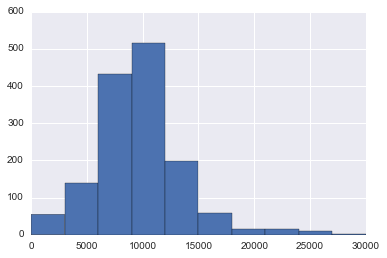

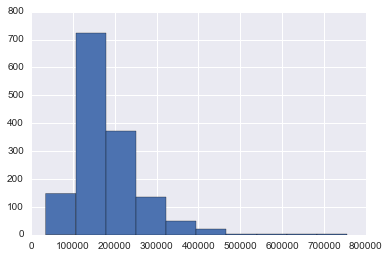

In [13]:
plt.hist(train.LotArea, range=[0, 30000])
plt.show()

plt.hist(train.SalePrice)
plt.show()

Axes(0.125,0.125;0.775x0.775)


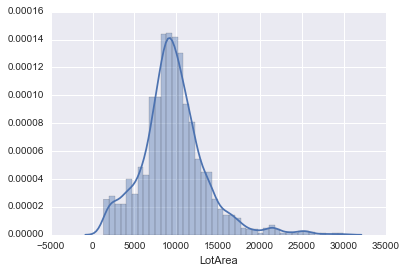

In [19]:
print(sns.distplot((train.LotArea[train.LotArea<30000])))



The first graph is a distribution of LotArea.  The above graph is close to a bell curve. This shows that LotArea has a normal distribution.

Axes(0.125,0.125;0.775x0.775)


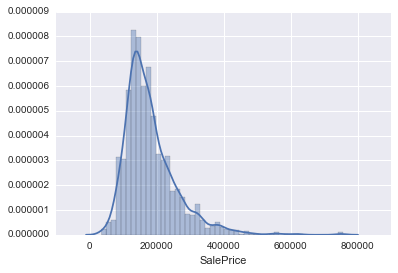

In [20]:
print(sns.distplot((train.SalePrice)))

The second graph is a distribution of SalePrice. The above graph appears to be somewhat right skewed. This suggests that the mean for SalePrice is greater than its median. 

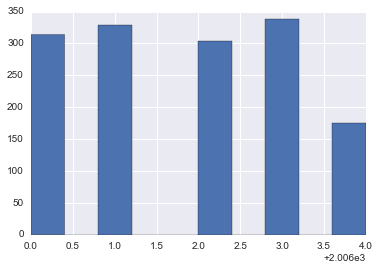

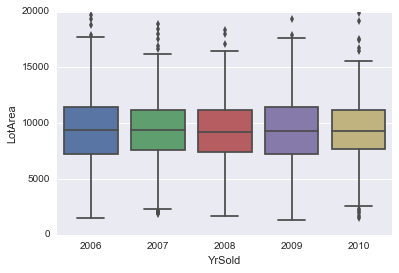

In [21]:
plt.hist(train.YrSold)
plt.show()

sns.boxplot(train.YrSold,train.LotArea[train.LotArea<20000])
#print(sns.distplot((data.YrSold)))

The next graph is a boxplot for YrSold and LotArea. The above graph shows that median of LotArea is almost same for the different years (2006-2010). Years 2006, 2007 and 2010 have many outliers, as can be seen from the graph. Year 2009 has significantly fewer outliers. Year 2007 and 2010 have small inter quartile range (IQR).  This signifies data is more consistent and lie closer to median.

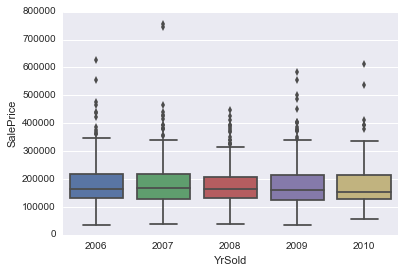

In [22]:
sns.boxplot(train.YrSold,train.SalePrice)

The last graph is a boxplot for YrSold and SalePrice. The above graph shows that every year (2006-2010) has significant outliers. All the outliers lie on the upper side of the graph. This shows that the outliers have higher SalePrice. Every year has similar median which shows that the median SalePrice remains unchanged over the years. This suggests that inflation in house prices over the years is negligible. The inter quartile range for 2008 is smaller than the rest. This shows that data is more consistent for year 2008.

In [14]:
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Preprocessing
Log transform

In [15]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Adding dummy values

In [16]:
all_data = pd.get_dummies(all_data)

In [17]:
all_data = all_data.fillna(all_data.mean())

### Correlation

In [18]:
j = 0
for i in (np.corrcoef(train[numeric_feats])[-1]):
    print (list(train)[j],"   ", i)
    j+=1

Id     0.986588401024
MSSubClass     0.998116677216
MSZoning     0.989717904014
LotFrontage     0.987514484167
LotArea     0.985821433484
Street     0.985641891161
Alley     0.994348832546
LotShape     nan
LandContour     0.955265842797
Utilities     0.990155965861
LotConfig     0.995612928864
LandSlope     0.987860677186
Neighborhood     nan
Condition1     0.984995731985
Condition2     nan
BldgType     0.966486457984
HouseStyle     nan
OverallQual     0.985748666377
OverallCond     0.990793979158
YearBuilt     0.988374151479
YearRemodAdd     0.979772203928
RoofStyle     0.983914669489
RoofMatl     0.977525927394
Exterior1st     0.916173468362
Exterior2nd     nan
MasVnrType     0.982114528447
MasVnrArea     0.98736074637
ExterQual     0.993706418259
ExterCond     0.988694101983
Foundation     0.971572784617
BsmtQual     0.984584094348
BsmtCond     nan
BsmtExposure     0.98859034081
BsmtFinType1     0.995181425216
BsmtFinSF1     0.981780808725
BsmtFinType2     0.979575543876
BsmtFinSF2 

IndexError: list index out of range

## Model
The model uses linear regression techniques. Input variables with normal distribution is better suited for such techniques. Hence we use log transformation to normalize the data. Firstly we normalize the SalePrice using log transformation.
A log transformation of a skewed variable decreases its skewness.  If a numeric variable has highly skewed, ie skewness > 0.75, we perform log transformation to reduce the skewness. This makes the trend detection in data easier. 
We fill the missing values in the data with the respective mean of their column. All the categorical variables are converted to numerical variables using get_dummies() function in the pandas library in python. The regression algorithms cannot process categorical variables. Therefore this conversion is needed. 


In [19]:
from sklearn.decomposition import PCA
X = all_data[:train.shape[0]]
pca = PCA(n_components=81)
# X is the matrix transposed (n samples on the rows, m features on the columns)
pca.fit(X)

X_new = pca.transform(X)
print (X_new)

[[  7.89064823e+01  -3.66886291e+01   8.70215304e-01 ...,   1.73596744e-01
   -4.91308186e-02   2.93108636e-03]
 [ -1.30614690e+01   1.74789590e-01  -1.01585869e+01 ...,  -4.82497277e-02
    6.29829202e-02   3.92235131e-01]
 [  1.38343535e+02  -2.80016748e+01   9.91517547e-01 ...,   1.49054674e-01
   -1.37270342e-01  -3.57597993e-02]
 ..., 
 [ -2.23327665e+02   1.30174055e+01   3.28700367e+01 ...,  -1.66604397e-01
   -3.15115184e-01   2.98936848e-01]
 [ -2.34562831e+02   4.48584221e+00   1.93569069e+01 ...,  -3.31033212e-02
   -8.53726570e-03  -4.18823335e-02]
 [ -1.97970273e+02   9.06487939e-01  -1.47619913e+01 ...,   4.88656645e-01
   -1.01601161e-01  -3.73568524e-01]]


In [20]:
from sklearn.feature_selection import VarianceThreshold
X = all_data[:train.shape[0]]
print (X.shape[1])
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
print (X.shape[1])

288
288


### Creating test and train set

In [21]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [25]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

### Implementing Ridge Regression

In [26]:
model_ridge = Ridge()

In [27]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

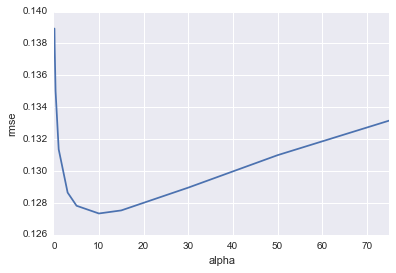

In [28]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " ")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [29]:
cv_ridge.min()

0.12733734668670754

### Implementing Lasso Regression

In [30]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)



In [31]:
rmse_cv(model_lasso).mean()

0.12314421090977437

In [38]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [39]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


In [40]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

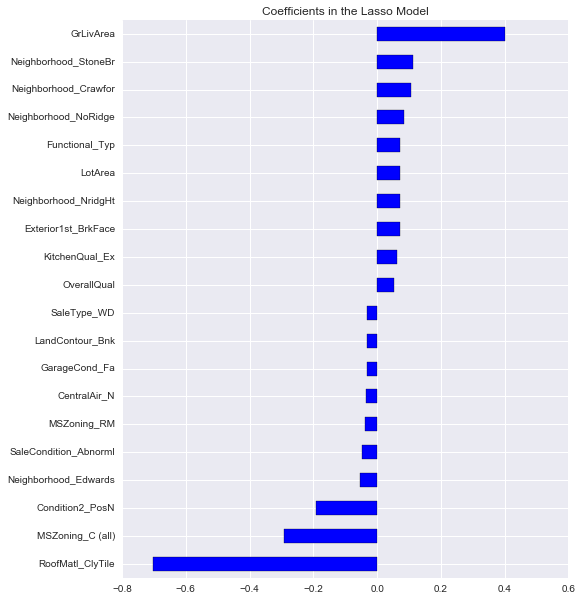

In [41]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

This graph shows that most important feature in predicting house price is GrLivArea. Few features have negative values. 

In [42]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
#preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [43]:
modelridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
ridge_preds = np.expm1(modelridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

### Predicting Final Values

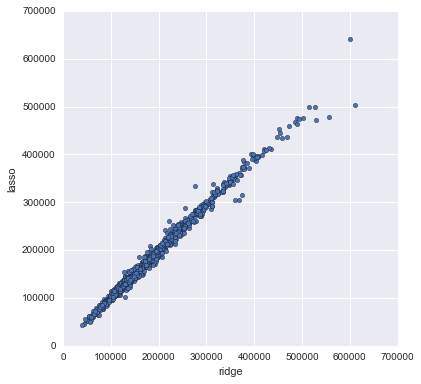

In [44]:
predictions = pd.DataFrame({"ridge":ridge_preds, "lasso":lasso_preds})

predictions.plot(x = "ridge", y = "lasso", kind = "scatter")

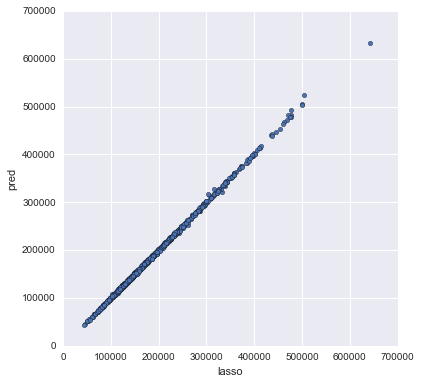

In [45]:
pred = 0.8*lasso_preds + 0.2*ridge_preds
predictions = pd.DataFrame({"lasso":lasso_preds,"pred":pred})
predictions.plot( x = "lasso", y = "pred",kind = "scatter")
#output = pd.DataFrame()

In [46]:
print (test.Id,pred)
output = pd.DataFrame({"id":test.Id, "SalePrice":pred})
output.to_csv("lassridge_sol.csv", index = False)

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, dtype: int64 [ 120050.55993664  151959.56647667  181263.68329508 ...,  170118.53747806
  119027.09825444  226580.11901536]


In [ ]:

#pca.fit(data_matrix)

plt.matshow(X_test.corr())

In [ ]:
from pylab import pcolor, show, colorbar, xticks, yticks
R = np.corrcoef(X_test)

pcolor(R)
colorbar()
yticks(np.arange(0.5,10.5),range(0,10))
xticks(np.arange(0.5,10.5),range(0,10))
show()

In [14]:
j = 0
for i in (np.corrcoef(train[numeric_feats])[-1]):
    print (list(train)[j],"   ", i)
    j+=1

Id     0.986588401024
MSSubClass     0.998116677216
MSZoning     0.989717904014
LotFrontage     0.987514484167
LotArea     0.985821433484
Street     0.985641891161
Alley     0.994348832546
LotShape     nan
LandContour     0.955265842797
Utilities     0.990155965861
LotConfig     0.995612928864
LandSlope     0.987860677186
Neighborhood     nan
Condition1     0.984995731985
Condition2     nan
BldgType     0.966486457984
HouseStyle     nan
OverallQual     0.985748666377
OverallCond     0.990793979158
YearBuilt     0.988374151479
YearRemodAdd     0.979772203928
RoofStyle     0.983914669489
RoofMatl     0.977525927394
Exterior1st     0.916173468362
Exterior2nd     nan
MasVnrType     0.982114528447
MasVnrArea     0.98736074637
ExterQual     0.993706418259
ExterCond     0.988694101983
Foundation     0.971572784617
BsmtQual     0.984584094348
BsmtCond     nan
BsmtExposure     0.98859034081
BsmtFinType1     0.995181425216
BsmtFinSF1     0.981780808725
BsmtFinType2     0.979575543876
BsmtFinSF2 

IndexError: list index out of range

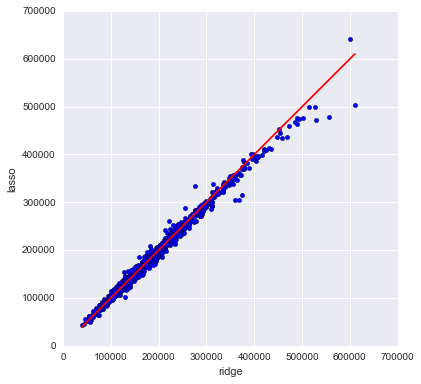

In [47]:
plt.scatter(ridge_preds, lasso_preds)
plt.xlabel('ridge')
plt.ylabel('lasso')
plt.plot( [min(ridge_preds),max(ridge_preds)], [min(ridge_preds),max(ridge_preds)], c="red")

The graph is almost linear, except towards the top Ridge model predicts higher house prices. The main reason because Lasso performs better is that it performs feature selection and parameter shrinkage automatically. This is not done by the Ridge algorithm

In [48]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

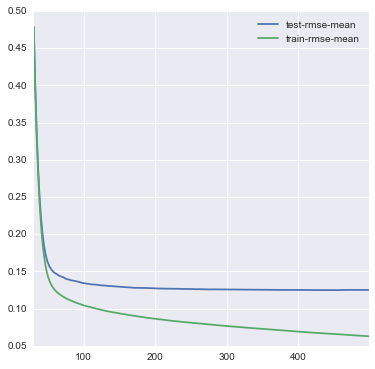

In [49]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [50]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [51]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

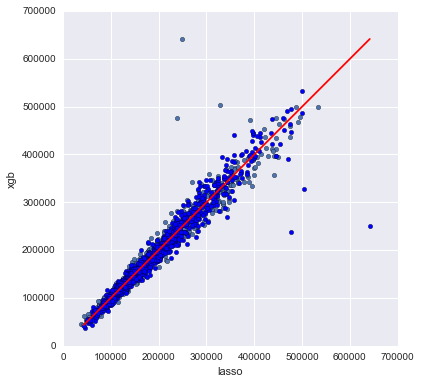

In [52]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

plt.scatter(lasso_preds,xgb_preds)
plt.xlabel('lasso')
plt.ylabel('xgb')
plt.plot( [min(lasso_preds),max(lasso_preds)], [min(lasso_preds),max(lasso_preds)], c="red")

In [53]:
final_preds = .7*lasso_preds+.3*xgb_preds

In [54]:
final_preds

array([ 120129.31638285,  153008.7854065 ,  181999.66786592, ...,
        165128.54225094,  119034.14941217,  227808.93476155])